In [151]:
import numpy as np
import os,glob
import music21
from music21 import *
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [152]:

def visualize_adjacency_matrix(adjacency_matrix):
    fig, ax = plt.subplots()
    cmap = plt.get_cmap("binary")
    n = len(adjacency_matrix)+1
    
    im = ax.imshow(adjacency_matrix, cmap=cmap)
    
    
    
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(np.arange(1, n + 1))
    ax.set_yticklabels(np.arange(1, n + 1))
    '''
    for i in range(n):
        for j in range(n):
            value = adjacency_matrix[i][j]
            ax.text(j, i, value, ha="center", va="center", color="r")
    '''
    # 設定 x, y 軸的 tick
    x_major_ticks = ticker.MultipleLocator(4)
    y_major_ticks = ticker.MultipleLocator(4)
    ax.xaxis.set_major_locator(x_major_ticks)
    ax.yaxis.set_major_locator(y_major_ticks)
    

    plt.show()

def extract_bars_from_midi(midi_file):
    midi_score = converter.parse(midi_file)
    bars = []
    for part in midi_score.parts:
        bar_stream = part.makeMeasures()
        for bar in bar_stream:
            bars.append(bar)
    return bars

def extract_bars_from_musicxml(xml_file):
    score = converter.parse(xml_file)
    bars = []
    for part in score.parts:
        measures = part.getElementsByClass('Measure')
        for measure in measures:
            bars.append(measure)
    return bars

def get_pitch_interval(note1, note2):
    if not isinstance(note1, note.Note) or not isinstance(note2, note.Note):
        return None
    else:
        return interval.notesToChromatic(note1, note2).semitones

def count_notes_in_bar(bar):
    notes_list = bar.flat.notes
    notes_counter = Counter()
    total_duration = 0.0
    
    for item in notes_list:
        if item.isNote:
            notes_counter[item.nameWithOctave] += item.duration.quarterLength
            total_duration += item.duration.quarterLength
        elif item.isChord:
            chord_duration = max([n.duration.quarterLength for n in item.notes])
            for n in item.notes:
                notes_counter[n.nameWithOctave] += chord_duration
            total_duration += chord_duration
                
    return notes_counter, total_duration

def are_bars_similar(bar1, bar2, threshold=0.9):
    bar1_notes, bar1_duration = count_notes_in_bar(bar1)
    bar2_notes, bar2_duration = count_notes_in_bar(bar2)

    shared_keys = set(bar1_notes.keys()) & set(bar2_notes.keys())
    total_shared_notes = sum([min(bar1_notes[key], bar2_notes[key]) for key in shared_keys])

    total_duration = bar1_duration + bar2_duration
    
    if total_duration != 0:
        similarity = (total_shared_notes * 2) / total_duration
    else:
        similarity = 0
    return similarity >= threshold


def create_adjacency_matrix(bars ,status):
    num_bars = len(bars)
    adjacency_matrix = np.zeros((num_bars, num_bars))

    if status == 'repeat':

        for i in range(num_bars):
            for j in range(i + 1, num_bars):
                if are_bars_similar(bars[i], bars[j]):
                    adjacency_matrix[i, j] = 1
                    adjacency_matrix[j, i] = 1

    elif status == 'rhythm':
        for i in range(num_bars):
            for j in range(i + 1, num_bars):
                bar1_notes = [n for n in bars[i].flat.notesAndRests if not isinstance(n, note.Rest)]
                bar2_notes = [n for n in bars[j].flat.notesAndRests if not isinstance(n, note.Rest)]

                distances = []
                for n1 in bar1_notes:
                    for n2 in bar2_notes:
                        dist = get_pitch_interval(n1, n2)
                        if dist is not None:
                            distances.append(dist)
                if len(distances) > 0:
                    mean_distance = sum(distances) / len(distances)

                    # Add a weight for the rhythmic relationship between the bars
                    # The weight is the absolute value of the difference between the durations of the first note/rest in each bar
                    bar1_duration = 0.0
                    for n in bar1_notes:
                        if n.duration.quarterLength > 0.0:
                            bar1_duration = n.duration.quarterLength
                            break

                    bar2_duration = 0.0
                    for n in bar2_notes:
                        if n.duration.quarterLength > 0.0:
                            bar2_duration = n.duration.quarterLength
                            break
                    '''
                    rhythm_weight = abs(bar1_duration - bar2_duration)
                    if (mean_distance - rhythm_weight) > 0:
                        adjacency_matrix[i][j] = 1
                        adjacency_matrix[j][i] = 1
                    '''
                    rhythm_weight = abs(bar1_duration - bar2_duration)
                    '''
                    adjacency_matrix[i][j] = mean_distance + rhythm_weight
                    adjacency_matrix[j][i] = mean_distance + rhythm_weight
                    '''
                    # Only show 1 or 0
                    adjacency_matrix[i][j] = 1 if mean_distance + rhythm_weight > 0 else 0
                    adjacency_matrix[j][i] = 1 if mean_distance + rhythm_weight > 0 else 0
                  
                    

    return adjacency_matrix

def merge_metrix(adj_1,adj_2):
    
    n = len(adj_1)
    
    merged_matrix = [[0] * (2 * n) for _ in range(2 * n)]
    
    for i in range(n):
        for j in range(n):
            merged_matrix[i][j] = adj_1[i][j]
    
    for i in range(n):
        for j in range(n):
            merged_matrix[n+i][n+j] = adj_2[i][j]
    
    return merged_matrix

def music_to_adjacency_metrix(file, bars_len):

    midi_file = file
    #midi_file = '../bestekar/midi_files/classic/schumann/schum_abegg_format0.mid'

    # Extract first 32 bars
    if midi_file.endswith(".mxl"):
        bars = extract_bars_from_musicxml(midi_file)[:bars_len]   #for xml files

    elif midi_file.endswith(".mid"):
        bars = extract_bars_from_midi(midi_file)[:bars_len]  #for midi files

    bars_repeat = create_adjacency_matrix(bars, 'repeat')
    bars_rhythm = create_adjacency_matrix(bars, 'rhythm')

    #merge_adj = merge_metrix(bars_repeat, bars_rhythm)

    return bars_repeat, bars_rhythm


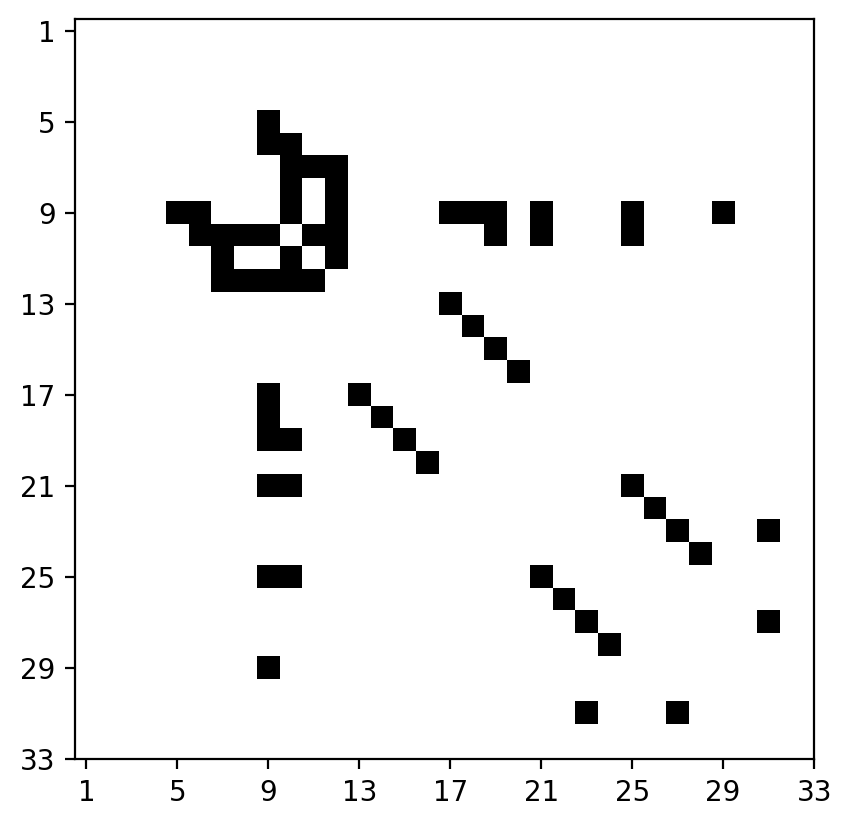

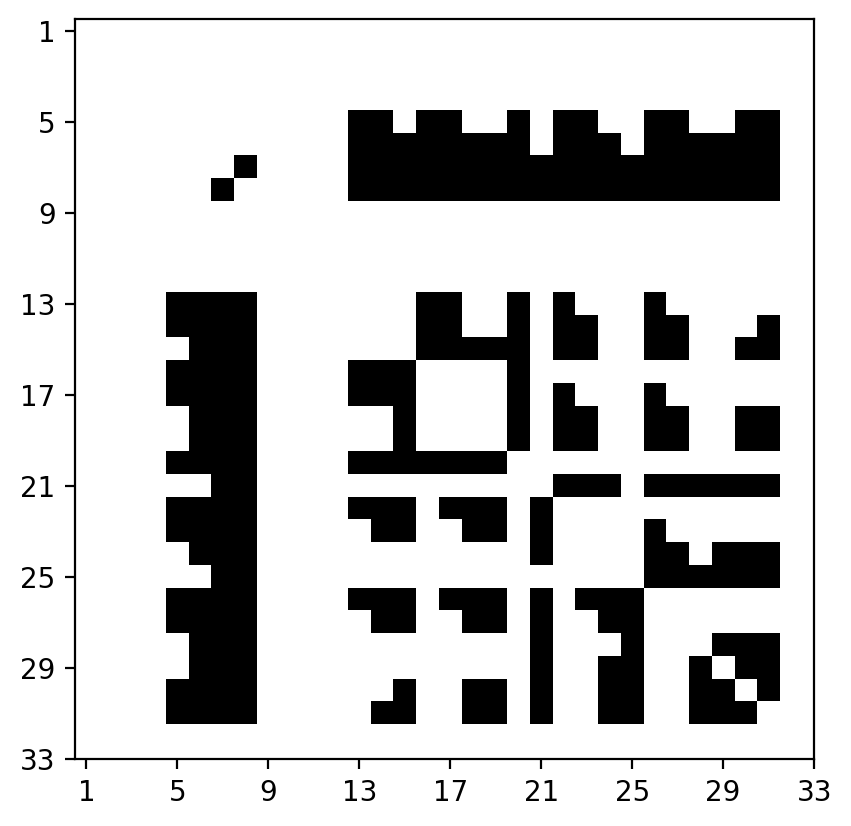

In [153]:
music_file = './music_files/test/Canon_in_D.mxl'

BARS_LENGTH = 32

bars_repeat, bars_rhythm = music_to_adjacency_metrix(music_file, BARS_LENGTH)

visualize_adjacency_matrix(bars_repeat)
visualize_adjacency_matrix(bars_rhythm)